In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pickle as pkl
import pandas as pd
dfs=dict()
for r in range (16,21):
    with open(f"data/df_20{r}_0.15.pkl", "rb") as f:
        file = pkl.load(f)
        dfs[r] = pd.DataFrame(file)

In [8]:
dfs[16].loc[dfs[16].Game_id==1].Goal.unique()

array([False,  True])

In [39]:
df=pd.concat([dfs[r] for r in range (16,20)]) 
df.head(5)

,Game_id,Game_time,Period,Time,Team,OppTeam,Goal,X,Y,Shooter,...,Previous_y,Previous_time_since,Previous_distance,Speed,Is_rebound,X_net,Shot_distance,Shot_angle,Rebound_angle,Year
0,1,71,1,01:11,TOR,OTT,False,-77.0,5.0,Mitchell Marner,...,11.0,1,17.088007,17.088007,False,12.0,13.000000,-22.619865,0.0,2016
1,1,173,1,02:53,OTT,TOR,False,86.0,13.0,Chris Kelly,...,-5.0,5,36.715120,7.343024,False,3.0,13.341664,77.005383,0.0,2016
2,1,241,1,04:01,OTT,TOR,False,23.0,-38.0,Cody Ceci,...,-38.0,18,95.000000,5.277778,False,66.0,76.157731,-29.931512,0.0,2016
3,1,286,1,04:46,OTT,TOR,False,33.0,-15.0,Erik Karlsson,...,-2.0,19,45.880279,2.414752,False,56.0,57.974132,-14.995079,0.0,2016
4,1,406,1,06:46,TOR,OTT,False,-34.0,28.0,Martin Marincin,...,34.0,16,81.221918,5.076370,False,55.0,61.717096,-26.980231,0.0,2016


In [35]:
df["Game_id"].nunique(),df.shape[0]

(1271, 305800)

In [41]:
label_encoder = LabelEncoder()
df['Goal'] = label_encoder.fit_transform(df['Goal'])

In [43]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(df['Shot_distance'], df['Goal'], test_size=0.2, random_state=12)

X_train = X_train.values.reshape(-1, 1)
X_valid = X_valid.values.reshape(-1, 1)

# Train a Logistic Regression model on the distance feature
clf_distance = LogisticRegression()
clf_distance.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_distance = clf_distance.predict(X_valid)

# Calculate and print the accuracy
accuracy_distance = accuracy_score(y_valid, y_pred_distance)
print(f'Accuracy with distance feature: {accuracy_distance}')


Accuracy with distance feature: 0.903646173969915


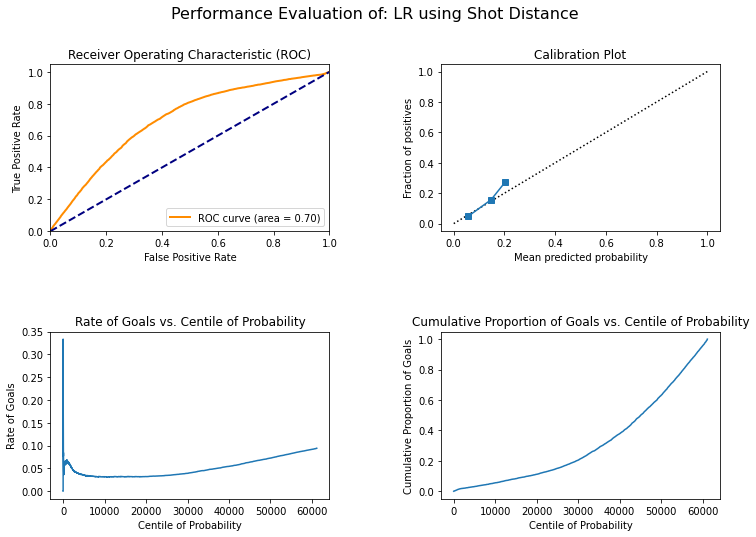

In [76]:
# Perform label encoding on the 'Goal' column
label_encoder = LabelEncoder()
df['Goal'] = label_encoder.fit_transform(df['Goal'])

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(df[['Shot_distance']], df['Goal'], test_size=0.2, random_state=42)

# Train a Logistic Regression model on the distance feature
clf_distance = LogisticRegression()
clf_distance.fit(X_train, y_train)

# Get predicted probabilities for the validation set
y_prob_distance = clf_distance.predict_proba(X_valid)[:, 1]

def plots(y_valid, y_prob, model_name):
    # Create a single figure with two subplots in one row
    #fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.suptitle(f'Performance Evaluation of: {model_name}', fontsize=16)


    # Plot ROC curve and calculate AUC
    fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
    roc_auc = roc_auc_score(y_valid, y_prob)

    axes[0,0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0,0].set_xlim([0.0, 1.0])
    axes[0,0].set_ylim([0.0, 1.05])
    axes[0,0].set_xlabel('False Positive Rate')
    axes[0,0].set_ylabel('True Positive Rate')
    axes[0,0].set_title('Receiver Operating Characteristic (ROC)')
    axes[0,0].legend(loc="lower right")

    

    axes[0,1].plot([0, 1], [0, 1], 'k:', label="Perfectly calibrated")
    prob_true, prob_pred = calibration_curve(y_valid, y_prob, n_bins=10)
    axes[0,1].plot(prob_pred, prob_true, 's-', label="%s" % ('clf_distance',))
    axes[0,1].set_ylabel('Fraction of positives')
    axes[0,1].set_xlabel('Mean predicted probability')
    axes[0,1].set_title('Calibration Plot')




    # Calculate and plot the rate of goals and cumulative proportion of goals
    sorted_indices = np.argsort(y_prob)
    sorted_goals = y_valid.iloc[sorted_indices]
    cumulative_goals = np.cumsum(sorted_goals)
    cumulative_total = np.arange(1, len(y_valid) + 1)

    rate_of_goals = cumulative_goals / cumulative_total

    axes[1,0].plot(np.arange(1, len(y_valid) + 1), rate_of_goals)
    axes[1,0].set_xlabel('Centile of Probability')
    axes[1,0].set_ylabel('Rate of Goals')
    axes[1,0].set_title('Rate of Goals vs. Centile of Probability')

    axes[1,1].plot(np.arange(1, len(y_valid) + 1), cumulative_goals / max(cumulative_goals))
    axes[1,1].set_xlabel('Centile of Probability')
    axes[1,1].set_ylabel('Cumulative Proportion of Goals')
    axes[1,1].set_title('Cumulative Proportion of Goals vs. Centile of Probability')

    # Display the figure with two subplots side by side
    plt.show()


plots(y_valid,y_prob_distance,"LR using Shot Distance")

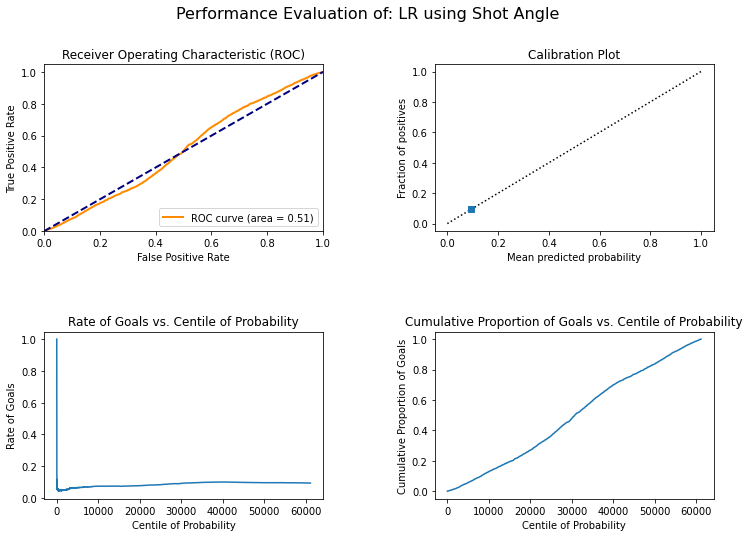

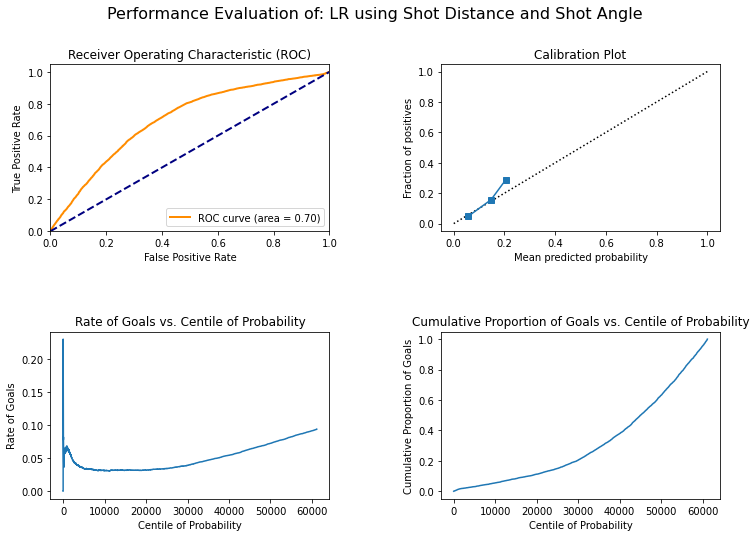

In [77]:
# Perform label encoding on the 'Goal' column
label_encoder = LabelEncoder()
df['Goal'] = label_encoder.fit_transform(df['Goal'])

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(['Goal'],inplace=False,axis=1), df['Goal'], test_size=0.2, random_state=42)

# Train a Logistic Regression model on the angle feature
clf_angle = LogisticRegression()
clf_angle.fit(X_train[['Shot_angle']], y_train)

# Get predicted probabilities for the validation set
y_prob_angle = clf_angle.predict_proba(X_valid[['Shot_angle']])[:, 1]

plots(y_valid,y_prob_angle,"LR using Shot Angle")

# Train a Logistic Regression model on both distance and angle features
X_train_both = X_train[['Shot_distance', 'Shot_angle']]
X_valid_both = X_valid[['Shot_distance', 'Shot_angle']]
clf_both = LogisticRegression()
clf_both.fit(X_train_both, y_train)

# Get predicted probabilities for the validation set
y_prob_both = clf_both.predict_proba(X_valid_both)[:, 1]

plots(y_valid,y_prob_both,"LR using Shot Distance and Shot Angle")


* Game_id: A unique identifier for each hockey game, allowing you to associate the data with a specific match.
* Game_time: The time elapsed within the game when the event occurred, typically in minutes and seconds.
* Period: Indicates which period of the game the event took place in (e.g., 1st period, 2nd period, etc.).
* Time: The time elapsed within the current period when the event occurred, usually in minutes and seconds.
* Team: The name or identifier of the team that performed the event.
* OppTeam: The name or identifier of the opposing team.
* Goal: A binary variable indicating whether a goal was scored (1 for a goal, 0 for no goal).
* X: The x-coordinate on the ice rink where the event occurred. This provides spatial information.
* Y: The y-coordinate on the ice rink where the event occurred. This, too, provides spatial information.
* Shooter: The player who took the shot or performed the event.
* Goalie: The goalkeeper (goalie) who was defending the net during the event.
* Type: Describes the type of event, which could include actions like a shot, a pass, a hit, or a faceoff, among others.
* Empty_net: A binary variable indicating whether the opposing team's net was empty (1 for empty, 0 for not empty). This is relevant in situations where the opposing team pulls their goalie to add an extra skater.
* Strength: Describes the on-ice strength situation, such as even strength (5 players vs. 5 players), power play (one team has more players due to a penalty), or penalty kill (one team has fewer players due to a penalty).
* Previous Event_type: The type of the previous event that occurred in the game.
* Previous_x: The x-coordinate of the previous event on the ice rink.
* Previous_y: The y-coordinate of the previous event on the ice rink.
* Previous Time Since: The time elapsed since the previous event occurred.
* Previous Distance: The distance between the current event and the previous event on the ice rink.
* Speed: The speed or velocity associated with the event, typically calculated based on the change in position and time.
* Is Rebound: A binary variable indicating whether the event was a rebound (1 for rebound, 0 for not a rebound).
* X_net: The x-coordinate of the net where the event occurred.
* Shot_distance: The distance between the shooter and the net when the event occurred.
* Shot_angle: The angle at which the shot was taken in relation to the net.
* Rebound Angle: The angle at which a rebound was taken in relation to the net.
* Year: The year in which the game took place or the data was recorded.